# Exact cover problem

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The problem is a type of an **exact cover problem**. We have a $M\times N$ grid, and a set of pieces. Then we need to find all the possible arangements for all the pieces that exactly cover the grid. To simplify this problem, it is illustrated here on a $3\times 3$ grid.

In [80]:
grid = [[0] * 3 for _ in range(3)]

P0_H = [[1,1,1],
        [0,0,0],
        [0,0,0]]

P0_V = [[1,0,0],
        [1,0,0],
        [1,0,0]]

P1_0 = [[1,1,0],
        [1,0,0],
        [0,0,0]]

P1_1 = [[1,1,0],
        [0,1,0],
        [0,0,0]]

P1_2 = [[0,1,0],
        [1,1,0],
        [0,0,0]]

P1_3 = [[1,0,0],
        [1,1,0],
        [0,0,0]]

pieces = [P0_H, P0_V, P1_0, P1_1, P1_2, P1_3, P1_0, P1_1, P1_2, P1_3]
tile_index = [0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
dimensions = [(3,1), (1,3), (2,2), (2,2), (2,2), (2,2), (2,2), (2,2), (2,2), (2,2)]

The empty $3\times 3$ grid is just a black square at this moment. No pieces have been placed in it yet.

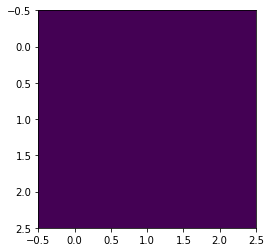

In [81]:
plt.imshow(grid)

In this example there are two shapes, and three pieces. There are two of the same kind of shape. The shapes that are used in this example are:

(-0.5, 2.5, 2.5, -0.5)

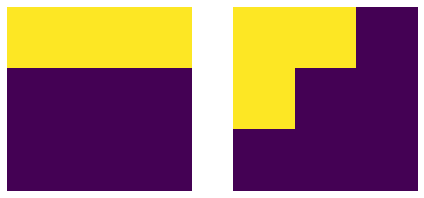

In [349]:
plt.subplots(1,2)
plt.subplot(121)
plt.imshow(P0_H)
plt.axis('off')
plt.subplot(122)
plt.imshow(P1_0)
plt.tight_layout()
plt.axis('off')

The shapes can also be rotated, and flipped. This leads to two different shapes for the first shape:

(-0.5, 2.5, 2.5, -0.5)

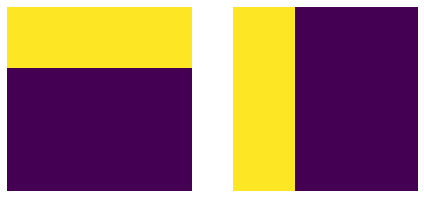

In [348]:
plt.subplots(1,2)
plt.subplot(121)
plt.imshow(P0_H)
plt.axis('off')
plt.subplot(122)
plt.imshow(P0_V)
plt.tight_layout()
plt.axis('off')

And the second shape has the following four different orientations:

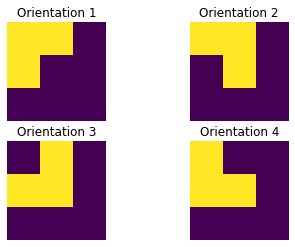

In [354]:
plt.subplots(2,2)
for i, s in enumerate([P1_0, P1_1, P1_2, P1_3]):
    plt.subplot(2,2,i + 1)
    plt.imshow(s)
    plt.axis('off')
    plt.title('Orientation {}'.format(i + 1))

So in total there are two shapes, with a total of six orientations. For the first shape there are two orientations, and the for the other two shapes there are four orientations. We also store the dimension of each shape. We need this information to figure out how many positions there on which we can place the pieces on the grid.

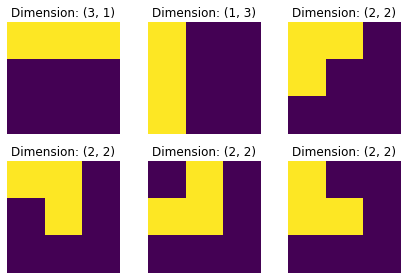

In [82]:
plt.subplots(2,3)
for i, p in enumerate(pieces[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(p)
    plt.axis('off')
    plt.title('Dimension: {}'.format(dimensions[i]))
plt.tight_layout()

For an orientated shape, this function will find all the possible positions for this shape. The result is transformed (with $\text{index} = y\cdot \text{grid_width} + x$) into a 1D array that can be used as a row in a matrix. The function returns all possible rows for the positions.

In [356]:
def get_rows(tile, shape_dim, grid_dim):
    L = []
    shape_width, shape_height = shape_dim
    grid_width, grid_height = grid_dim
    for y in range(grid_height - shape_height + 1):
        for x in range(grid_width - shape_width + 1):
            L.append((x, y))
    rows = []
    for offset_x, offset_y in L:
        row = [0] * grid_width * grid_height
        for x in range(shape_height):
            for y in range(shape_width):
                if tile[x][y]:
                    row[((x + offset_y) * grid_width) + y + offset_x] = 1
        rows.append(row)
    return rows

For the first piece, we will get three possible positions:

[[1, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 1]]

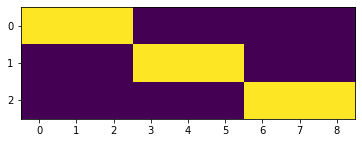

In [357]:
R = get_rows(pieces[0], dimensions[0], (3, 3))
plt.imshow(R); R

With this function we create all the rows for all the orientated pieces, and combine them into a single matrix $R$. We will also add a few columns $H$ to the front to identify which piece it belongs to. So the resulting matrix is:

$$ 
M = \begin{bmatrix}
H && R
\end{bmatrix}
$$

In [184]:
def get_matrix_for_pieces(pieces, dimensions, n_pieces):
    rows = []
    for i, p in enumerate(pieces):
        header = [0] * n_pieces
        header[tile_index[i]] = 1
        piece_rows = get_rows(p, dimensions[i], (3,3))
        piece_rows = [header + pr for pr in piece_rows]
        rows += piece_rows
    return rows

If we visualize $M$:

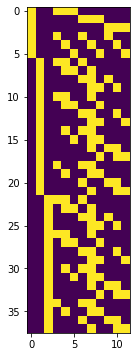

In [185]:
M = np.matrix(get_matrix_for_pieces(pieces, dimensions, 3))
plt.figure(figsize=(14,6))
plt.imshow(M)

The algorithm that we are going to use is a modified version of __Algorithm X__, which is created by Donald. E. Knuth. The algorithm is as follows:

1. Select a determined column $\text{col}$ (up to the number of pieces).
2. Find a row where $M[\text{row, col}] = 1$.
3. Delete all the other rows from $M$ where $M[j, \text{col}] = 1$ for $j = 0..\text{rows}$.
4. Recursively call this method on $M$.

To do this efficiently, we will first create a function which we can use to prune the rows in $M$. For the desired row, we check each column for that row which contains a one, and then remove all the other rows for which the column is also 1.

This reduces the amount of possible solutions. It is also possible that there are less than 3 remaining rows, meaning that a solution was not possible with that configuration of pieces.

In [318]:
def prune_rows(row_index, M):
    rows = []
    for j in range(M.shape[1]):
        if M[row_index, j] == 1:
            for i in range(M.shape[0]):
                if M[i, j] == 1 and i != row_index:
                    rows.append(i)
    return rows

To illustrate what this does, let's take a look at the initial state of $M$:

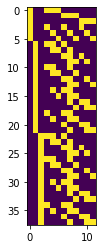

In [323]:
plt.imshow(M)

Now if we prune for the first row, it will remove all the other possible choices for the first piece because it has the header with the ones.

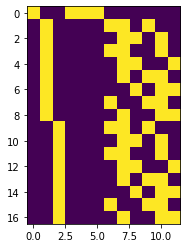

In [359]:
N = np.delete(M, prune_rows(0, M), axis=0)
plt.imshow(N)

If we now repeat this another iteration, and select the second row to use for pruning, we get:

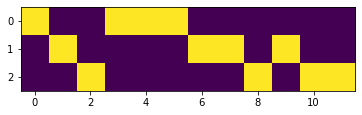

In [322]:
O = np.delete(N, prune_rows(1, N), axis=0)
plt.imshow(O)

Which is a solution! But it is also possible to have less than $3$ (in this case) of rows left in $M$, meaning that the solution is invalid.

If we program this into a recursive function which prints the solution:

In [414]:
def solve(M, S, cols, i=0):
    global sub_plot
    
    if M.shape[0] < cols:
        return  # invalid solution
    
    if M.shape[0] == cols:
        print('Solution:\r\n{}'.format(M))
        return
    
    for row in range(M.shape[0]):
        if M[row, i] == 1:
            N = np.delete(M, prune_rows(row, M), axis=0)
            solve(N, S, cols, i + 1)

S = []    
solve(np.array(M), S, cols=3)

Solution:
[[1 0 0 1 1 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 1 0 1 0 0]
 [0 0 1 0 0 0 0 0 1 0 1 1]]
Solution:
[[1 0 0 1 1 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 1 0 0 1]
 [0 0 1 0 0 0 1 0 0 1 1 0]]
Solution:
[[1 0 0 1 1 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 1 1]
 [0 0 1 0 0 0 1 1 0 1 0 0]]
Solution:
[[1 0 0 1 1 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0]
 [0 0 1 0 0 0 0 1 1 0 0 1]]
Solution:
[[1 0 0 0 0 0 0 0 0 1 1 1]
 [0 1 0 1 1 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 1 0 0 0]]
Solution:
[[1 0 0 0 0 0 0 0 0 1 1 1]
 [0 1 0 0 1 1 0 0 1 0 0 0]
 [0 0 1 1 0 0 1 1 0 0 0 0]]
Solution:
[[1 0 0 0 0 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 0 1 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0 0 0]]
Solution:
[[1 0 0 0 0 0 0 0 0 1 1 1]
 [0 1 0 1 0 0 1 1 0 0 0 0]
 [0 0 1 0 1 1 0 0 1 0 0 0]]
Solution:
[[1 0 0 1 0 0 1 0 0 1 0 0]
 [0 1 0 0 1 1 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 1 1]]
Solution:
[[1 0 0 1 0 0 1 0 0 1 0 0]
 [0 1 0 0 1 1 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 1 1]]
Solution:
[[1 0 0 1 0 0 1 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0 1 1]
 [0 0 1 0 1 1 0 

We get all the possible configurations for this puzzle.

But to visualize it is not a bad thing, so let's do that:

Number of solutions: 16


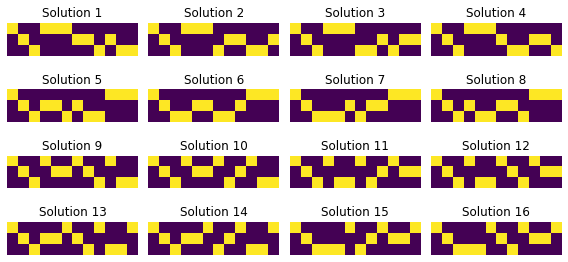

In [392]:
def solve(M, S, cols, i=0):
    global sub_plot
    
    if M.shape[0] == cols:
        #print('Solution: {}'.format(M))
        plt.subplot(4, 4, sub_plot)
        plt.imshow(M)
        plt.axis('off')
        S.append(M)
        plt.title('Solution {}'.format(sub_plot))
        sub_plot += 1
        return
    
    for row in range(M.shape[0]):
        if M[row, i] == 1:
            N = np.delete(M, prune_rows(row, M), axis=0)
            solve(N, S, cols, i + 1)
    
plt.subplots(4, 4, figsize=(8, 4))
sub_plot = 1

S = []    
solve(np.array(M), S, cols=3)
print('Number of solutions: {}'.format(len(S)))
plt.tight_layout()

We can also convert the solution back to a 2D image.

In [413]:
def show_solution(S, D):
    R = [[0] * D[1] for _ in range(D[0])]
    for shape_id, s in enumerate(S):
        for i in range(len(s)-3):
            if s[3:][i]:  # the first columns belong to the header
                r = i // 3
                c = i % 3
                R[c][r] = shape_id
    plt.imshow(R)

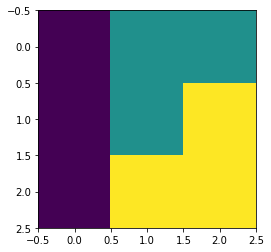

In [406]:
show_solution(S[0], (3, 3))

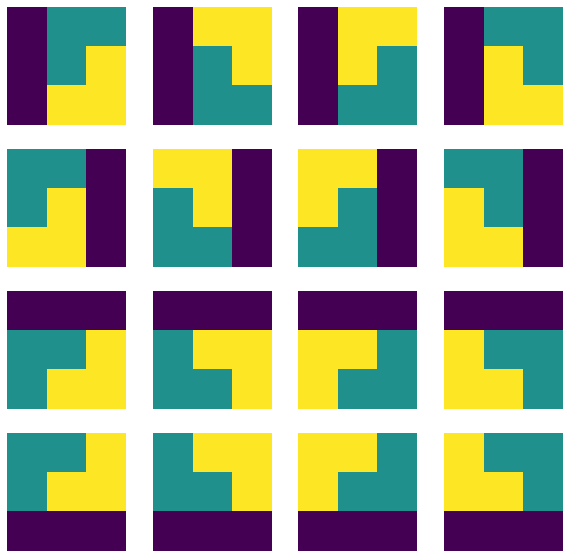

In [411]:
plt.subplots(4,4, figsize=(10, 10))
for i, s in enumerate(S):
    plt.subplot(4,4,i+1)
    show_solution(s, (3, 3))
    plt.axis('off')